# Transformers

## Componentes essenciais

Neste notebook, iremos trabalhar e entender um pouco com os componentes essencias que compõem os *Transformers*. Mais especificamente, vamos retomar alguns conceitos que vimos previamente no curso (como *skip connections*) e mais recentemente em mecanismos de *atenção*.

### Mecanismo de atenção *scaled dot-product*

Como visto em aulas passadas, existe uma infinidade de mecanismos de atenção propostos por artigos da área de processamento de linguagem natural e afins, como: *additive attention*, *deep attention*, entre outros. Porém, todos comportilham da mesma ideia de computar similaridade entre uma *query* (consulta) e uma "base de dados" (*keys*), criando assim o que é chamado de *attention weights*, que serão utilizados como pesos para uma soma ponderada de certos valores (*values*).

Uma forma natural de computar similaridade entre duas coisas é através do produto interno entre vetores. E é assim que a ideia de *dot-product attention* surge! Essa forma de atenção assume a seguinte fórmula, que recebe o nome de *self-attention*:

$$
\mathbf{Y} = \text{Softmax}[\mathbf{X} \mathbf{X^T}] \mathbf{X}
$$

Note que com essa formulação, nós não temos parâmetros aprendíveis durante a atenção, logo podemos utilizar a matriz $\mathbf{\tilde{X}} = \mathbf{XU}$ como sendo a matriz que iremos computar a atenção:

$$
\mathbf{Y} = \text{Softmax}[\mathbf{\tilde{X}} \mathbf{\tilde{X}^T}] \mathbf{\tilde{X}} = \text{Softmax}[\mathbf{XU} \mathbf{U^{T}X^{T}}] \mathbf{XU}
$$

Mesmo introduzindo essa flexibilidade através de um parâmetro aprendível, note que a matriz $\mathbf{XU} \mathbf{U^{T}X^{T}}$ é simétrica, algo que nem sempre queremos que seja verdade. Tome como exemplo as palavras `banana` e `fruta`. Queremos que `banana` tenha uma associação forte com a palavra `fruta` e que `fruta` tenha uma associação mais fraca com a palavra `banana`, uma vez que toda banana é uma fruta mas nem toda fruta é uma banana. Para conseguirmos tal comportamento, podemos criar uma matriz de pesos diferentes para cada componente da nossa atenção, criando assim as matrizes de *query* $(\mathbf{Q} = \mathbf{XW^{(q)}})$, *key* $(\mathbf{K} = \mathbf{XW^{(k)}})$ e *value* $(\mathbf{V} = \mathbf{XW^{(v)}})$.

$$
\mathbf{Y} = \text{Softmax}[\mathbf{Q} \mathbf{K^T}] \mathbf{V}
$$

- Nesse caso, a matriz $\mathbf{X}$ possui tamanho $N \times D$, sendo $N$ o tamanho da sequência e $D$ a dimensão de *embedding* escolhida. Já as matrizes $\mathbf{W^{(q)}}$, $\mathbf{W^{(k)}}$, $\mathbf{W^{(v)}}$, possuem tamanho: $D \times D_k$, $D \times D_k$ e $D \times D_v$. As matrizes $\mathbf{W^{(q)}}$ e $\mathbf{W^{(k)}}$ possuem a mesma dimensão para que o produto interno funcione e, tipicamente, definimos $D_k = D$, bem como $D_v = D$, para que a saída final tenha as mesmas dimensões da entrada, facilitando a inclusão de conexões residuais.

Existe um último refinamento que podemos fazer para a nossa camada de *self-attention*. Note que ao derivarmos a função `softmax` para computar os gradientes durante o *backpropagation*, as entradas de maior magnitude terão gradientes menores (similar com o que acontece com as funções `tanh` e `sigmoid`). Para ajudar a prevenir esse problema, podemos reescalar o produto interno $\mathbf{Q} \mathbf{K^T}$ antes de computarmos uma `softmax`. Para isso, iremos dividir essa parte por $\sqrt{D_k}$, sendo $D_k$ a dimensão "interna" do produto matricial $\mathbf{Q} \mathbf{K^T}$. A intuição por trás disso pode ser lida no livro do [Bishop](https://www.bishopbook.com/).

Agora, vamos implementar essa ideia em PyTorch!

Utilizaremos o seguinte fluxo como referência, onde `mat mul` representa uma operação de multiplicação de matrizes e `scale` refere-se a normalização por $\sqrt{D_k}$.

<div style="text-align: center;">
    <img src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/attention_scheme.png?raw=true"/>
</div>

1. Implemente o `AttentionBlock` com o *scaled dot-product*.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, d_model, hidden_size):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(hidden_size))
        self.Wq = nn.Linear(d_model, hidden_size)
        self.Wk = nn.Linear(d_model, hidden_size)
        self.Wv = nn.Linear(d_model, hidden_size)

    def forward(self, q, k, v):
        dot = torch.bmm(self.Wq(q), self.Wk(k).transpose(1, 2))
        attn_weights = F.softmax(dot / self.scale, dim=1)
        attn_outputs = torch.bmm(attn_weights, self.Wv(v))

        return attn_outputs, attn_weights

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

Tamanho da saída da atenção: torch.Size([1, 10, 5])
Dimensão da matriz de atenção: torch.Size([1, 10, 10])


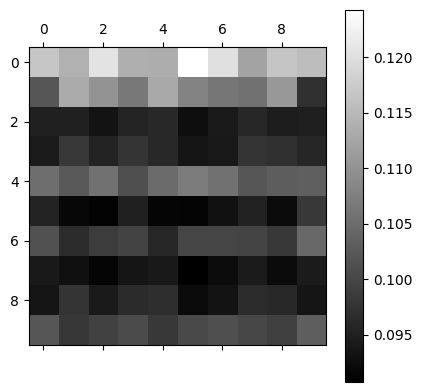

In [2]:
import matplotlib.pyplot as plt

x = torch.rand(1, 10, 5)  # (batch_size, seq_lengh, n_features)
attention = AttentionBlock(5, 5)

attn_outputs, attn_weights = attention(x, x, x)
print('Tamanho da saída da atenção:', attn_outputs.shape)
print('Dimensão da matriz de atenção:', attn_weights.shape)

plt.matshow(attn_weights[0].detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

O código implementado pela classe `AttentionBlock` representa o que chamamos de uma **cabeça de atenção**. Tipicamente, utilizaremos múltiplas cabeças para capturar diferentes padrões da entrada, tendo como análogo a passagem de múltiplos filtros em uma camada convolucional quando trabalhamos com imagens!

Suponha que temos $H$ cabeças de atenção, onde a cabeça $h$ possui a seguinte formulação: $\mathbf{H_h} = \text{Attention}(\mathbf{Q_h}, \mathbf{K_h}, \mathbf{V_h})$. Então, a nossa saída será representada por $\mathbf{Y} = \text{concat}[\mathbf{H_1}, \mathbf{H_2}, \dots, \mathbf{H}_H]$. Como cada matriz $\mathbf{H}_h$ possui dimensão $N \times D_v$, a matriz final $\mathbf{Y}$ terá dimensão $N \times HD_v$. Para combinarmos as múltiplas interpretações e aplicarmos futuramente conexões residuais, precisaremos realizar uma múltiplicação da concatenação das cabeças por uma matriz $\mathbf{W}^{(o)}$, de dimensão $HD_v \times D$. Com isso, teremos que a saída do nosso mecanismo de atenção de múltiplas cabeças (*multi-head attention*) será: $\mathbf{Y} = \text{concat}[\mathbf{H_1}, \mathbf{H_2}, \dots, \mathbf{H}_H]\mathbf{W}^{(o)}$.

> Tipicamente, escolhemos $D_v = D / H$, de forma que a matriz concatenada tenha dimensão $N \times D$.

<div style="text-align: center;">
    <img width=600 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/mha_details.png?raw=true"/>
</div>

Vamos implementar essa ideia em Pytorch.

Utilizaremos o seguinte fluxo como referência, onde cada bloco *self-attention* é uma instância da classe `AttentionBlock` passando `q = k = v = x`.

<div style="text-align: center;">
    <img width=600 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/mha_scheme.png?raw=true"/>
</div>

2. Implemente a `MultiHeadAttention`.

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        assert d_model % nhead == 0, f'{nhead} must divide {d_model}'

        hidden_size = d_model // nhead
        self.Wo = nn.Linear(nhead * hidden_size, d_model)  # nhead * hidden_size == d_model! (faremos assim apenas pra ser mais didático)

        attention_blocks = []
        for i in range(nhead):
            attn_block = AttentionBlock(d_model, hidden_size)
            attention_blocks.append(attn_block)

        self.attention_blocks = nn.ModuleList(attention_blocks)

    def forward(self, q, k, v):
        attn_outputs = []
        attn_weights = []

        for attention in self.attention_blocks:
            attn_output, attn_weight = attention(q, k, v)
            attn_outputs.append(attn_output)
            attn_weights.append(attn_weight)

        attn_outputs = torch.cat(attn_outputs, dim=-1)
        attn_outputs = self.Wo(attn_outputs)

        return attn_outputs, attn_weights

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [4]:
x = torch.rand(1, 10, 40)  # (batch_size, seq_lengh, n_features)
mha = MultiHeadAttention(40, 4)

attn_outputs, attn_weights = mha(x, x, x)
print('Tamanho da saída da atenção:', attn_outputs.shape)
print('Número de matrizes de atenção:', len(attn_weights))
print('Dimensão de uma matriz de atenção:', attn_weights[0].shape)

Tamanho da saída da atenção: torch.Size([1, 10, 40])
Número de matrizes de atenção: 4
Dimensão de uma matriz de atenção: torch.Size([1, 10, 10])


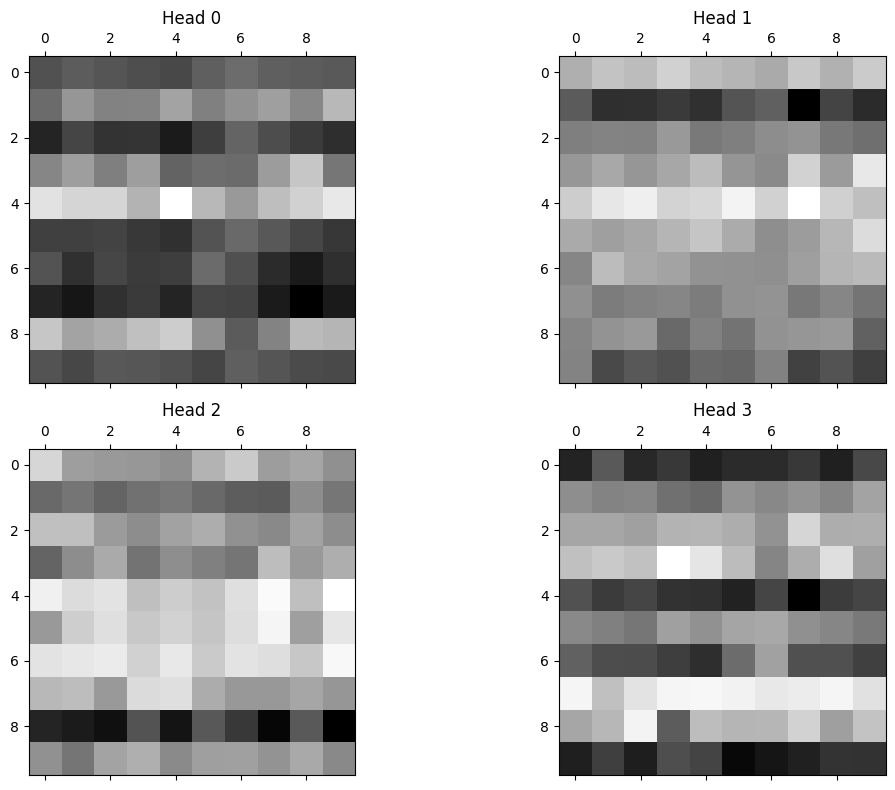

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

counter = 0
for i in range(2):
    for j in range(2):
        axs[i, j].set_title(f'Head {counter}')
        axs[i,j].matshow(attn_weights[counter][0].detach().numpy(), cmap='gray')
        counter += 1

fig.tight_layout()

### Construção de uma camada do *Transformer*

Entendendo o que um bloco de *multi-head attention* faz, conseguimos prosseguir na construção da camada de um *Transformer*. Após a aplicação de um mecanismo de atenção, iremos realizar um *batch normalization* da saída do mecanismo juntamente com a adição da sua entrada, tendo assim uma conexão residual da seguinte forma, onde simplificaremos a notação de *self-attention* como sendo $\text{MHA}(\mathbf{X})$:

$$
\mathbf{Z} = \text{LayerNorm}[\text{MHA}(\mathbf{X}) + \mathbf{X}]
$$

- Há a opção de também aplicarmos uma camada de *batch normalization* antes de computarmos a atenção da entrada da camada, já que isso pode resultar em uma otimização mais efetiva, ficando da seguinte forma: $\mathbf{Z} = \text{MHA}(\text{LayerNorm}[\mathbf{X}]) + \mathbf{X}$.

Note que até então, todas as operações feitas pela camada do nosso *Transformer* são operações lineares, cujas saídas residem no subespaço vetorial definido pelos vetores de entrada, limitando a capacidade de expressividade da nossa rede. Para lidar com isso, podemos introduzir uma sequência de camadas não-lineares após o cálculo de $\mathbf{Z}$. Em outras palavras, podemos pós-processar a saída da nossa camada de atenção através de uma rede MLP (*multilayer perceptron*) da seguinte forma (note que ainda trabalharemos com conexões residuais e *batch normalization*):

$$
\mathbf{\tilde{X}} = \text{LayerNorm}[\text{MLP}(\mathbf{Z}) + \mathbf{Z}]
$$

- Aqui também temos a opção de aplicar a camada de normalização antes de pós-processarmos o vetor $\mathbf{Z}$, ficando da seguinte forma: $\mathbf{\tilde{X}} = \text{MLP}(\text{LayerNorm}[\mathbf{Z}]) + \mathbf{Z}$.


Com isso, concluímos os componentes fundamentais de uma camada da arquitetura *Transformers*. Uma sumarização de todos esses passos pode ser vista através do seguinte esquema.

<div style="text-align: center;">
    <img width=250 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/transformer_layer_scheme.png?raw=true"/>
</div>

Vamos implementar essa ideia em PyTorch agora.

3. Implemente a classe `TransformerLayer`.

In [6]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, norm_first):
        """
        Implementação de uma camada da arquitetura Transformers.

        Argumentos
        ----------
            d_model (int): dimensão do vetor de entrada
            nhead (int): número de cabeças de atenção
            dim_feedforward (int): tamanho do estado oculto da MLP
            norm_first (bool): flag indicando se queremos aplicar batch normalization antes ou depois das operações
        """
        super().__init__()

        self.norm_first = norm_first
        self.norm1 = nn.BatchNorm1d(d_model)
        self.norm2 = nn.BatchNorm1d(d_model)
        self.mha = MultiHeadAttention(d_model, nhead)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, x):
        if self.norm_first:
            x_norm = self.apply_batch_norm(x, self.norm1)
            attn_outputs, attn_weights = self.mha(x_norm, x_norm, x_norm)
            z = attn_outputs + x

            z_norm = self.apply_batch_norm(z, self.norm2)
            outputs = self.mlp(z_norm) + z
        else:
            attn_outputs, attn_weights = self.mha(x, x, x)
            z = self.apply_batch_norm(attn_outputs + x, self.norm1)
            outputs = self.apply_batch_norm(self.mlp(z) + z, self.norm2)

        return outputs, attn_weights

    def apply_batch_norm(self, x, norm_layer):
        x = x.transpose(1, 2)  # batch norm espera dimensões (batch_size, n_features, seq_length)
        x = norm_layer(x)
        x = x.transpose(1, 2)  # camadas futuras esperam (batch_size, seq_length, n_features)

        return x

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [8]:
x = torch.rand(1, 10, 512)  # (batch_size, seq_lengh, n_features)
layer = TransformerLayer(d_model=512, nhead=8, dim_feedforward=2048, norm_first=False)

outputs, attn_weights = layer(x)
print('Tamanho da saída da camada:', outputs.shape)
print('Número de matrizes de atenção:', len(attn_weights))
print('Dimensão de uma matriz de atenção:', attn_weights[0].shape)

Tamanho da saída da camada: torch.Size([1, 10, 512])
Número de matrizes de atenção: 8
Dimensão de uma matriz de atenção: torch.Size([1, 10, 10])


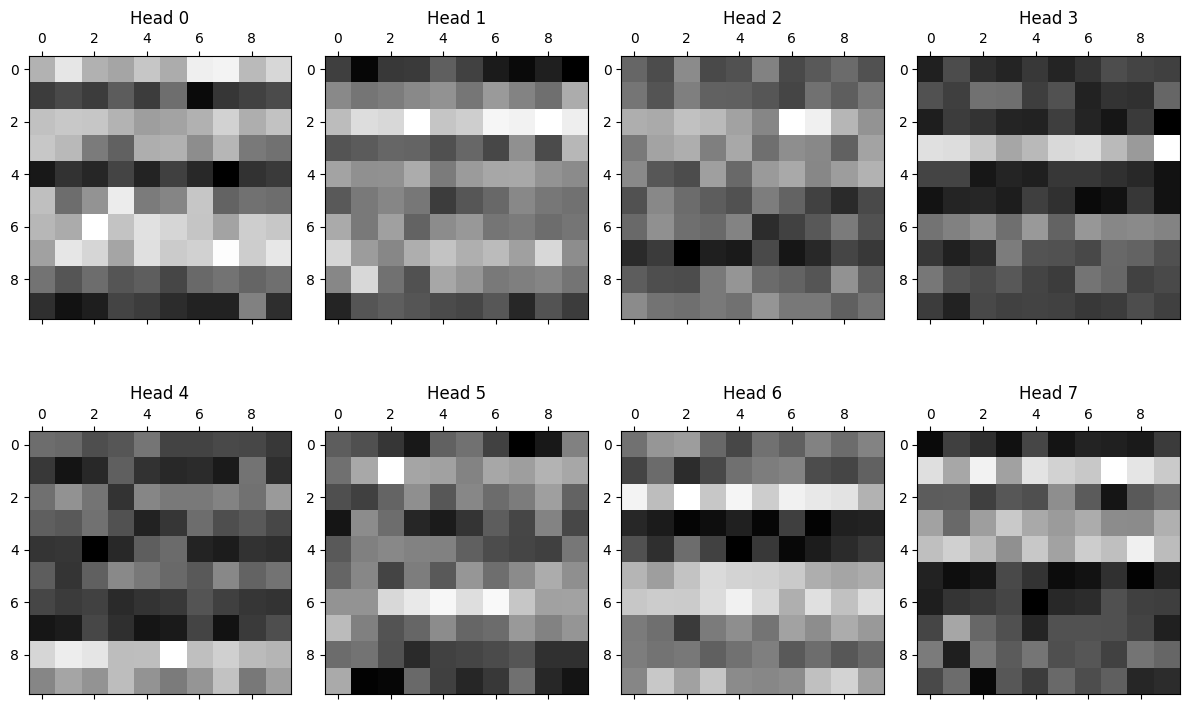

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(12, 8))

counter = 0
for i in range(2):
    for j in range(4):
        axs[i, j].set_title(f'Head {counter}')
        axs[i,j].matshow(attn_weights[counter][0].detach().numpy(), cmap='gray')
        counter += 1

fig.tight_layout()

### Positional encoding

Na arquitetura de um *Transformer*, as matrizes $\mathbf{W_h^{(q)}}$, $\mathbf{W_h^{(k)}}$, $\mathbf{W_h^{(v)}}$ são compartilhadas pelos *tokens* de entrada, assim como o restante da rede. Sendo assim, um *Transformer* é **equivariante** à permutações da entrada! As frases em inglês: *The food was bad, not good at all* e *The food was good, not bad at all*, possuem as mesmas palavras, porém, possuem sentidos completamente diferentes.

Para solucionar esse problema, iremos adicionar ao *embedding* da nossa entrada uma noção de posição através de um *positional encoding*, em outras palavras, o nosso novo *embedding* para o n-ésimo token será: $\mathbf{\tilde{x}}_n = \mathbf{x}_n + \mathbf{p}_n$, sendo $\mathbf{x}_n$ o *embedding* original do n-ésimo *token* e $\mathbf{p}_n$ um vetor de mesma dimensão que possui uma informação da posição daquele *token* na entrada. Existem diversas formas de gerar o vetor $\mathbf{p}$_n, para mais discussões sobre essas diferentes estratégias, consulte o livro do [Bishop](https://www.bishopbook.com/).

Aqui, iremos utilizar uma técnica baseada em funções senoidais introduzida por *Vaswani et al.*, em 2017, no seu artigo [*Attention Is All You Need*](https://arxiv.org/pdf/1706.03762.pdf). Para uma da posição $n$, teremos um vetor de *position-encoding* $\mathbf{p}_n$ associado, tendo seus componentes construídos da seguinte forma:
$$
\mathbf{p}_n^{(i)} =
\begin{cases}
   \sin{\left(\dfrac{n}{L^{i / D}}\right)}, & \text{ se } i \text{ for par (da forma } 2k \text{),} \\
   \cos{\left(\dfrac{n}{L^{(i-1) / D}}\right)}, & \text{ se } i \text{ for ímpar (da forma } 2k+1 \text{),} \\
\end{cases}
$$

   - No artigo original, temos que $L = 10000$ (escolhido de forma empírica).

Vamos implementar essa ideia em PyTorch.

In [10]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # fazendo com que "pe" seja um buffer (variável não treinável)

    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [11]:
x = torch.rand(1, 128, 512)
encoding = PositionalEncoding(d_model=512)

x = encoding(x)
print('Tamanho dos vetores depois do positional encoding:', x.shape)

Tamanho dos vetores depois do positional encoding: torch.Size([1, 128, 512])


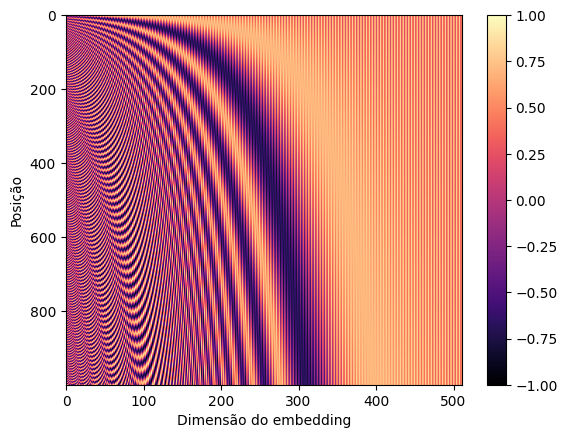

In [12]:
plt.imshow(encoding.pe[0, :1000], cmap='magma', aspect='auto')
plt.xlabel('Dimensão do embedding')
plt.ylabel('Posição')

plt.colorbar()
plt.show()

Finalmente, iremos juntar todos os bloquinhos desenvolvidos até então para criar um *Transformers* de múltiplas camadas.

> - O que estamos fazendo aqui na verdade é implementando os bloquinhos que fazem parte da etapa do *encoder* da arquitetura final, justificando assim o nome da classe ser `TransformerEncoder`.

4. Implemente o modelo `TransformerEncoder`.

In [13]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, nhead, dim_feedforward, norm_first, num_layers):
        super().__init__()

        self.pe = PositionalEncoding(d_model)
        self.embedding = nn.Linear(input_size, d_model)

        layers = []
        for i in range(num_layers):
            transformer_layer = TransformerLayer(d_model, nhead, dim_feedforward, norm_first)
            layers.append(transformer_layer)

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        attn_weights_per_layer = []
        outputs = self.pe(self.embedding(x))

        for layer in self.layers:
            outputs, attn_weights = layer(outputs)
            attn_weights_per_layer.append(attn_weights)

        return outputs, attn_weights_per_layer

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [14]:
x = torch.rand(1, 10, 4)
encoder = TransformerEncoder(input_size=4, d_model=16, nhead=4,
                             dim_feedforward=64, norm_first=False, num_layers=2)

outputs, attn_weights = encoder(x)
print('Dimensão da saída:', outputs.shape)
print('Número de atenções de cada camada:', len(attn_weights[0]))
print('Dimensão das matrizes de atenção:', attn_weights[0][0].shape)

Dimensão da saída: torch.Size([1, 10, 16])
Número de atenções de cada camada: 4
Dimensão das matrizes de atenção: torch.Size([1, 10, 10])


## Exemplo prático: previsão de litologia utilizando *Transformers*

Para finalizar, iremos realizar um exemplo prático do que desenvolvemos até então em um contexto geológico através da previsão de litologia dado um conjunto de séries temporais como entrada. Para mais detalhes sobre os dados utilizados, bem como uma versão do mesmo exemplo utilizando LSTMs, consulte o seguinte [notebook](https://colab.research.google.com/drive/1PHgm0yveHSfFXt-ODtQ9_XFdqufN7qP6?usp=sharing#scrollTo=V9xCHeZxv_9c), desenvolvido pelo monitor João Pedro.

> - Iremos apenas carregar os dados de interesse e usar o mesmo pré-processamento discutido nesse outro notebook, logo não daremos muito foco para essas partes aqui.

In [15]:
import pandas as pd

lithology_keys = {
    0: 'Sandstone',
    1: 'Sandstone/Shale',
    2: 'Shale',
    3: 'Marl',
    4: 'Dolomite',
    5: 'Limestone',
    6: 'Chalk',
    7: 'Halite',
    8: 'Anhydrite',
    9: 'Tuff',
    10: 'Coal',
    11: 'Basement'
}

lithology_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}

def process_data(df):
    interested = ['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'GR', 'NPHI', 'RHOB', 'DTC']
    df = df[interested]

    df = df.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY' : 'CLASS'})
    df['CLASS'] = df['CLASS'].map(lithology_numbers)

    df = df[['WELL', 'GR', 'NPHI', 'RHOB', 'DTC', 'CLASS']]
    df = df.dropna()

    return df

In [16]:
train_df = pd.read_csv('/pgeoprj/ciag2023/datasets/force_dataset/train.csv', sep=';')
test_df = pd.read_csv('/pgeoprj/ciag2023/datasets/force_dataset/hidden_test.csv', sep=';')

train_df = process_data(train_df)
test_df = process_data(test_df)

In [17]:
print('Dimensão dos dados de treino:', train_df.shape)
train_df.head()

Dimensão dos dados de treino: (721358, 6)


,WELL,GR,NPHI,RHOB,DTC,CLASS
4238,15/9-13,55.892757,0.765867,1.774626,147.837677,0
4239,15/9-13,60.929138,0.800262,1.800986,142.382431,2
4240,15/9-13,62.117264,0.765957,1.817696,138.258331,2
4241,15/9-13,61.010860,0.702521,1.829333,139.198914,2
4242,15/9-13,58.501236,0.639708,1.813854,144.290085,2


In [18]:
train_df[['GR', 'NPHI', 'RHOB', 'DTC']].describe()

,GR,NPHI,RHOB,DTC
count,721358.000000,721358.000000,721358.000000,721358.000000
mean,74.725545,0.333061,2.332880,105.319368
std,33.578914,0.130785,0.231722,27.801146
min,0.898921,-0.035822,0.720971,7.415132
25%,52.649197,0.241795,2.162753,83.480913
50%,74.190857,0.329171,2.374316,98.042912
75%,92.530827,0.424883,2.516248,127.789511
max,1076.963867,0.999570,3.364472,320.478882


In [19]:
print('Dimensão dos dados de teste:', test_df.shape)
test_df.head()

Dimensão dos dados de teste: (95839, 6)


,WELL,GR,NPHI,RHOB,DTC,CLASS
54,15/9-23,116.596664,0.580942,2.052875,147.079727,2
55,15/9-23,117.188751,0.588395,2.103997,149.681824,2
56,15/9-23,119.035187,0.490395,2.135201,151.130005,2
57,15/9-23,114.921494,0.392217,2.142983,148.035446,2
58,15/9-23,113.003197,0.390906,2.148073,146.129105,2


In [20]:
test_df[['GR', 'NPHI', 'RHOB', 'DTC']].describe()

,GR,NPHI,RHOB,DTC
count,95839.000000,95839.000000,95839.000000,95839.000000
mean,76.436733,0.317597,2.348914,109.467793
std,34.107008,0.126137,0.207036,29.709637
min,1.132300,-0.015035,1.127937,48.268532
25%,54.033358,0.220684,2.202484,83.760567
50%,76.488625,0.324343,2.393359,105.751129
75%,96.862106,0.412304,2.509702,138.500847
max,1141.292114,0.906257,3.353153,178.817993


Visualização simples da distribuição de em ambos conjuntos de dados.

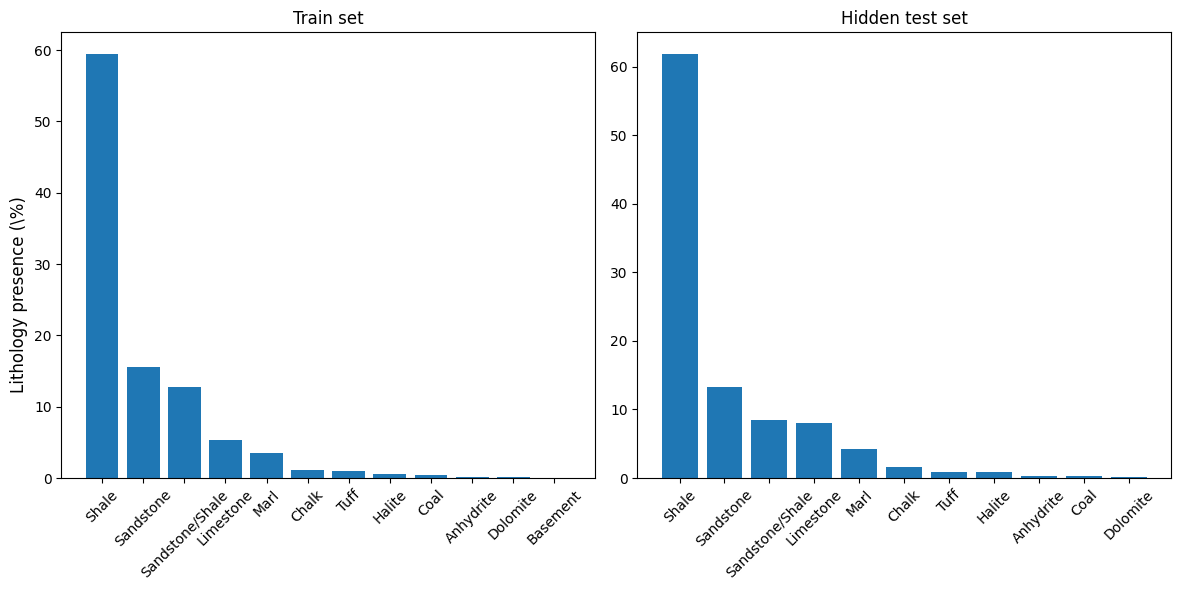

In [21]:
import numpy as np

train_names = []
train_percentage = []
train_counts = train_df['CLASS'].value_counts()

test_names = []
test_percentage = []
test_counts = test_df['CLASS'].value_counts()

for item in train_counts.items():
    train_names.append(lithology_keys[item[0]])
    train_percentage.append(100 * float(item[1])/train_df.shape[0])

for item in test_counts.items():
    test_names.append(lithology_keys[item[0]])
    test_percentage.append(100 * float(item[1])/test_df.shape[0])

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].set_title('Train set')
ax[0].bar(x=np.arange(len(train_names)), height=train_percentage)
ax[0].set_xticks(np.arange(len(train_names)))
ax[0].set_xticklabels(train_names, rotation=45)

ax[1].set_title('Hidden test set')
ax[1].bar(x=np.arange(len(test_names)), height=test_percentage)
ax[1].set_xticks(np.arange(len(test_names)))
ax[1].set_xticklabels(test_names, rotation=45)

fig.supylabel('Lithology presence (\%)')
fig.tight_layout()

In [22]:
from torch.utils.data import Dataset, DataLoader

class FORCE(Dataset):
    def __init__(self, dataframe, window_size = 50):
        # Convert dataframe to NumPy array
        self.data_array = dataframe.drop(columns=['WELL']).values
        self.groups = dataframe['WELL'].values
        self.window_size = window_size
        self.group_indices = self.compute_group_indices()

    def __len__(self):
        return len(self.group_indices)

    def __getitem__(self, idx):

        group_idx, data_idx = self.group_indices[idx]
        sequence_ = self.data_array[data_idx:data_idx+self.window_size]
        sequence = sequence_[:,:-1]
        label = sequence_[:,-1]

        sequence = (sequence - sequence.mean())/sequence.std()

        return torch.from_numpy(sequence).to(torch.float32), torch.from_numpy(label).to(torch.long)

    def compute_group_indices(self):
        unique_groups, group_counts = np.unique(self.groups, return_counts=True)
        group_indices = []
        start_idx = 0
        for group, count in zip(unique_groups, group_counts):
            end_idx = start_idx + count - self.window_size - 1
            indices = [(i, idx) for i, idx in enumerate(range(start_idx, end_idx))]
            group_indices.extend(indices)
            start_idx = end_idx
        return group_indices

In [23]:
window_size = 50
train_dataset = FORCE(train_df, window_size)
test_dataset = FORCE(test_df, window_size)

print('Número de dados de treino:', len(train_dataset))
print('Número de dados de teste:', len(test_dataset))

Número de dados de treino: 716360
Número de dados de teste: 95329


In [24]:
X, y = train_dataset[0]
print('Dimensão das features:', X.shape)
print('Dimensão das anotações:', y.shape)

Dimensão das features: torch.Size([50, 4])
Dimensão das anotações: torch.Size([50])


### Treinamento do modelo sobre os dados da competição

In [25]:
has_cuda = torch.cuda.is_available()
device = torch.device('cuda' if has_cuda else 'cpu')

print('Utilizando:', device)

Utilizando: cuda


In [26]:
class LithologyModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, dim_feedforward, norm_first, num_layers):
        super().__init__()

        self.encoder = TransformerEncoder(input_size, d_model, nhead,
                                          dim_feedforward, norm_first, num_layers)

        self.classifier = nn.Linear(d_model, output_size)

    def forward(self, x):
        outputs, attn_weights = self.encoder(x)
        outputs = self.classifier(outputs)

        return outputs, attn_weights

In [27]:
import torch.optim as optim

batch_size = 1024
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

model = LithologyModel(input_size=4, output_size=12, d_model=16, nhead=4,
                           dim_feedforward=32, norm_first=False, num_layers=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad == True)
print('Número de parâmetros do nosso modelo:', n_params)

print('\nComponentes do modelo final:')
print(model)

Número de parâmetros do nosso modelo: 2508

Componentes do modelo final:
LithologyModel(
  (encoder): TransformerEncoder(
    (pe): PositionalEncoding()
    (embedding): Linear(in_features=4, out_features=16, bias=True)
    (layers): ModuleList(
      (0): TransformerLayer(
        (norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mha): MultiHeadAttention(
          (Wo): Linear(in_features=16, out_features=16, bias=True)
          (attention_blocks): ModuleList(
            (0-3): 4 x AttentionBlock(
              (Wq): Linear(in_features=16, out_features=4, bias=True)
              (Wk): Linear(in_features=16, out_features=4, bias=True)
              (Wv): Linear(in_features=16, out_features=4, bias=True)
            )
          )
        )
        (mlp): Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
         

In [30]:
from tqdm.notebook import tqdm

def train_epoch(model, dataloader, optimizer, criterion):
    epoch_loss = 0

    model.train()
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X = X.to(device)
        y = y.to(device)

        outputs, attn_weights = model(X)

        optimizer.zero_grad()
        loss = criterion(outputs.transpose(1, 2), y)  # a loss function espera que a saída do modelo seja (batch_size, out_size, seq_lengh)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if (batch + 1) % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Batch [{batch+1}/{len(dataloader)}] -> batch loss: {loss.item():.5f}')

    epoch_loss /= len(dataloader)
    return epoch_loss

In [35]:
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    epoch_loss = train_epoch(model, train_dataloader, optimizer, criterion)

    print(f'Epoch [{epoch}/{num_epochs}] -> mean epoch loss: {epoch_loss:.5f}')

  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [1/20], Batch [100/699] -> batch loss: 1.87119
Epoch [1/20], Batch [200/699] -> batch loss: 1.32047
Epoch [1/20], Batch [300/699] -> batch loss: 1.08941
Epoch [1/20], Batch [400/699] -> batch loss: 1.02549
Epoch [1/20], Batch [500/699] -> batch loss: 0.94360
Epoch [1/20], Batch [600/699] -> batch loss: 1.01609
Epoch [1/20] -> mean epoch loss: 1.26938


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [2/20], Batch [100/699] -> batch loss: 0.96886
Epoch [2/20], Batch [200/699] -> batch loss: 0.93191
Epoch [2/20], Batch [300/699] -> batch loss: 0.89268
Epoch [2/20], Batch [400/699] -> batch loss: 0.88748
Epoch [2/20], Batch [500/699] -> batch loss: 0.89974
Epoch [2/20], Batch [600/699] -> batch loss: 0.89043
Epoch [2/20] -> mean epoch loss: 0.92199


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [3/20], Batch [100/699] -> batch loss: 0.92337
Epoch [3/20], Batch [200/699] -> batch loss: 0.93221
Epoch [3/20], Batch [300/699] -> batch loss: 0.93621
Epoch [3/20], Batch [400/699] -> batch loss: 0.87220
Epoch [3/20], Batch [500/699] -> batch loss: 0.87156
Epoch [3/20], Batch [600/699] -> batch loss: 0.88590
Epoch [3/20] -> mean epoch loss: 0.90156


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [4/20], Batch [100/699] -> batch loss: 0.89208
Epoch [4/20], Batch [200/699] -> batch loss: 0.85914
Epoch [4/20], Batch [300/699] -> batch loss: 0.93835
Epoch [4/20], Batch [400/699] -> batch loss: 0.86650
Epoch [4/20], Batch [500/699] -> batch loss: 0.90131
Epoch [4/20], Batch [600/699] -> batch loss: 0.88215
Epoch [4/20] -> mean epoch loss: 0.89151


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [5/20], Batch [100/699] -> batch loss: 0.93120
Epoch [5/20], Batch [200/699] -> batch loss: 0.90219
Epoch [5/20], Batch [300/699] -> batch loss: 0.91626
Epoch [5/20], Batch [400/699] -> batch loss: 0.85738
Epoch [5/20], Batch [500/699] -> batch loss: 0.91422
Epoch [5/20], Batch [600/699] -> batch loss: 0.92012
Epoch [5/20] -> mean epoch loss: 0.88365


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [6/20], Batch [100/699] -> batch loss: 0.88298
Epoch [6/20], Batch [200/699] -> batch loss: 0.84021
Epoch [6/20], Batch [300/699] -> batch loss: 0.88967
Epoch [6/20], Batch [400/699] -> batch loss: 0.89374
Epoch [6/20], Batch [500/699] -> batch loss: 0.86919
Epoch [6/20], Batch [600/699] -> batch loss: 0.84181
Epoch [6/20] -> mean epoch loss: 0.87723


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [7/20], Batch [100/699] -> batch loss: 0.88777
Epoch [7/20], Batch [200/699] -> batch loss: 0.85565
Epoch [7/20], Batch [300/699] -> batch loss: 0.84980
Epoch [7/20], Batch [400/699] -> batch loss: 0.90584
Epoch [7/20], Batch [500/699] -> batch loss: 0.86565
Epoch [7/20], Batch [600/699] -> batch loss: 0.89025
Epoch [7/20] -> mean epoch loss: 0.87219


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [8/20], Batch [100/699] -> batch loss: 0.88959
Epoch [8/20], Batch [200/699] -> batch loss: 0.86777
Epoch [8/20], Batch [300/699] -> batch loss: 0.88333
Epoch [8/20], Batch [400/699] -> batch loss: 0.90780
Epoch [8/20], Batch [500/699] -> batch loss: 0.86770
Epoch [8/20], Batch [600/699] -> batch loss: 0.90790
Epoch [8/20] -> mean epoch loss: 0.86820


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [9/20], Batch [100/699] -> batch loss: 0.85943
Epoch [9/20], Batch [200/699] -> batch loss: 0.92046
Epoch [9/20], Batch [300/699] -> batch loss: 0.84855
Epoch [9/20], Batch [400/699] -> batch loss: 0.87951
Epoch [9/20], Batch [500/699] -> batch loss: 0.87118
Epoch [9/20], Batch [600/699] -> batch loss: 0.83800
Epoch [9/20] -> mean epoch loss: 0.86467


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [10/20], Batch [100/699] -> batch loss: 0.84652
Epoch [10/20], Batch [200/699] -> batch loss: 0.88043
Epoch [10/20], Batch [300/699] -> batch loss: 0.89886
Epoch [10/20], Batch [400/699] -> batch loss: 0.88669
Epoch [10/20], Batch [500/699] -> batch loss: 0.87264
Epoch [10/20], Batch [600/699] -> batch loss: 0.89771
Epoch [10/20] -> mean epoch loss: 0.86161


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [11/20], Batch [100/699] -> batch loss: 0.85643
Epoch [11/20], Batch [200/699] -> batch loss: 0.87462
Epoch [11/20], Batch [300/699] -> batch loss: 0.84520
Epoch [11/20], Batch [400/699] -> batch loss: 0.88598
Epoch [11/20], Batch [500/699] -> batch loss: 0.84823
Epoch [11/20], Batch [600/699] -> batch loss: 0.86714
Epoch [11/20] -> mean epoch loss: 0.85914


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [12/20], Batch [100/699] -> batch loss: 0.87373
Epoch [12/20], Batch [200/699] -> batch loss: 0.81900
Epoch [12/20], Batch [300/699] -> batch loss: 0.88173
Epoch [12/20], Batch [400/699] -> batch loss: 0.85517
Epoch [12/20], Batch [500/699] -> batch loss: 0.90030
Epoch [12/20], Batch [600/699] -> batch loss: 0.84377
Epoch [12/20] -> mean epoch loss: 0.85676


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [13/20], Batch [100/699] -> batch loss: 0.87227
Epoch [13/20], Batch [200/699] -> batch loss: 0.85135
Epoch [13/20], Batch [300/699] -> batch loss: 0.89908
Epoch [13/20], Batch [400/699] -> batch loss: 0.85397
Epoch [13/20], Batch [500/699] -> batch loss: 0.87675
Epoch [13/20], Batch [600/699] -> batch loss: 0.87853
Epoch [13/20] -> mean epoch loss: 0.85433


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [14/20], Batch [100/699] -> batch loss: 0.86472
Epoch [14/20], Batch [200/699] -> batch loss: 0.86337
Epoch [14/20], Batch [300/699] -> batch loss: 0.81906
Epoch [14/20], Batch [400/699] -> batch loss: 0.80933
Epoch [14/20], Batch [500/699] -> batch loss: 0.86497
Epoch [14/20], Batch [600/699] -> batch loss: 0.81396
Epoch [14/20] -> mean epoch loss: 0.85196


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [15/20], Batch [100/699] -> batch loss: 0.84454
Epoch [15/20], Batch [200/699] -> batch loss: 0.86868
Epoch [15/20], Batch [300/699] -> batch loss: 0.88072
Epoch [15/20], Batch [400/699] -> batch loss: 0.86501
Epoch [15/20], Batch [500/699] -> batch loss: 0.88777
Epoch [15/20], Batch [600/699] -> batch loss: 0.85078
Epoch [15/20] -> mean epoch loss: 0.84994


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [16/20], Batch [100/699] -> batch loss: 0.88657
Epoch [16/20], Batch [200/699] -> batch loss: 0.84537
Epoch [16/20], Batch [300/699] -> batch loss: 0.84512
Epoch [16/20], Batch [400/699] -> batch loss: 0.85845
Epoch [16/20], Batch [500/699] -> batch loss: 0.85539
Epoch [16/20], Batch [600/699] -> batch loss: 0.87399
Epoch [16/20] -> mean epoch loss: 0.84765


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [17/20], Batch [100/699] -> batch loss: 0.84141
Epoch [17/20], Batch [200/699] -> batch loss: 0.83466
Epoch [17/20], Batch [300/699] -> batch loss: 0.83337
Epoch [17/20], Batch [400/699] -> batch loss: 0.86737
Epoch [17/20], Batch [500/699] -> batch loss: 0.82471
Epoch [17/20], Batch [600/699] -> batch loss: 0.86549
Epoch [17/20] -> mean epoch loss: 0.84559


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [18/20], Batch [100/699] -> batch loss: 0.82705
Epoch [18/20], Batch [200/699] -> batch loss: 0.86639
Epoch [18/20], Batch [300/699] -> batch loss: 0.79603
Epoch [18/20], Batch [400/699] -> batch loss: 0.78784
Epoch [18/20], Batch [500/699] -> batch loss: 0.82477
Epoch [18/20], Batch [600/699] -> batch loss: 0.82204
Epoch [18/20] -> mean epoch loss: 0.84271


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [19/20], Batch [100/699] -> batch loss: 0.87131
Epoch [19/20], Batch [200/699] -> batch loss: 0.85821
Epoch [19/20], Batch [300/699] -> batch loss: 0.83387
Epoch [19/20], Batch [400/699] -> batch loss: 0.82732
Epoch [19/20], Batch [500/699] -> batch loss: 0.86384
Epoch [19/20], Batch [600/699] -> batch loss: 0.80974
Epoch [19/20] -> mean epoch loss: 0.84062


  0%|          | 0/699 [00:00<?, ?it/s]

Epoch [20/20], Batch [100/699] -> batch loss: 0.84476
Epoch [20/20], Batch [200/699] -> batch loss: 0.81955
Epoch [20/20], Batch [300/699] -> batch loss: 0.81873
Epoch [20/20], Batch [400/699] -> batch loss: 0.79852
Epoch [20/20], Batch [500/699] -> batch loss: 0.83241
Epoch [20/20], Batch [600/699] -> batch loss: 0.85340
Epoch [20/20] -> mean epoch loss: 0.83799


### Avaliando a performance da rede em dados de teste

In [36]:
def evaluate(model, dataloader, criterion):
    total_loss = 0.0

    predictions = torch.zeros(len(dataloader), batch_size, window_size).to(device)
    labels = torch.zeros_like(predictions)

    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X = X.to(device)
            y = y.to(device)

            outputs, attn_weights = model(X)

            loss = criterion(outputs.transpose(1, 2), y)  # a loss function espera que a saída do modelo seja (batch_size, out_size, seq_lengh)
            total_loss += loss.item()

            predictions[batch] = outputs.argmax(dim=-1)
            labels[batch] = y

    total_loss /= len(dataloader)
    return total_loss, predictions, labels

In [37]:
total_loss, predictions, labels = evaluate(model, test_dataloader, criterion)

print(f'Mean hidden test loss: {total_loss:.5f}')

  0%|          | 0/93 [00:00<?, ?it/s]

Mean hidden test loss: 0.88343


In [38]:
from torchmetrics import Accuracy, Precision, Recall, ConfusionMatrix

acc = Accuracy(task = 'multiclass', num_classes = 12).to(device)
prec = Precision(task = 'multiclass', average='macro', num_classes = 12).to(device)
recall = Recall(task = 'multiclass', average='macro', num_classes = 12).to(device)

print(f'Acurácia: {(100*acc(labels, predictions)):.2f}%')
print(f'Precisão: {(100*prec(labels, predictions)):.2f}%')
print(f'Recall: {(100*recall(labels, predictions)):.2f}%')

Acurácia: 70.22%
Precisão: 29.00%
Recall: 42.50%


Computando uma matriz de confusão para verificarmos a qualidade do nosso modelo nos dados de teste.

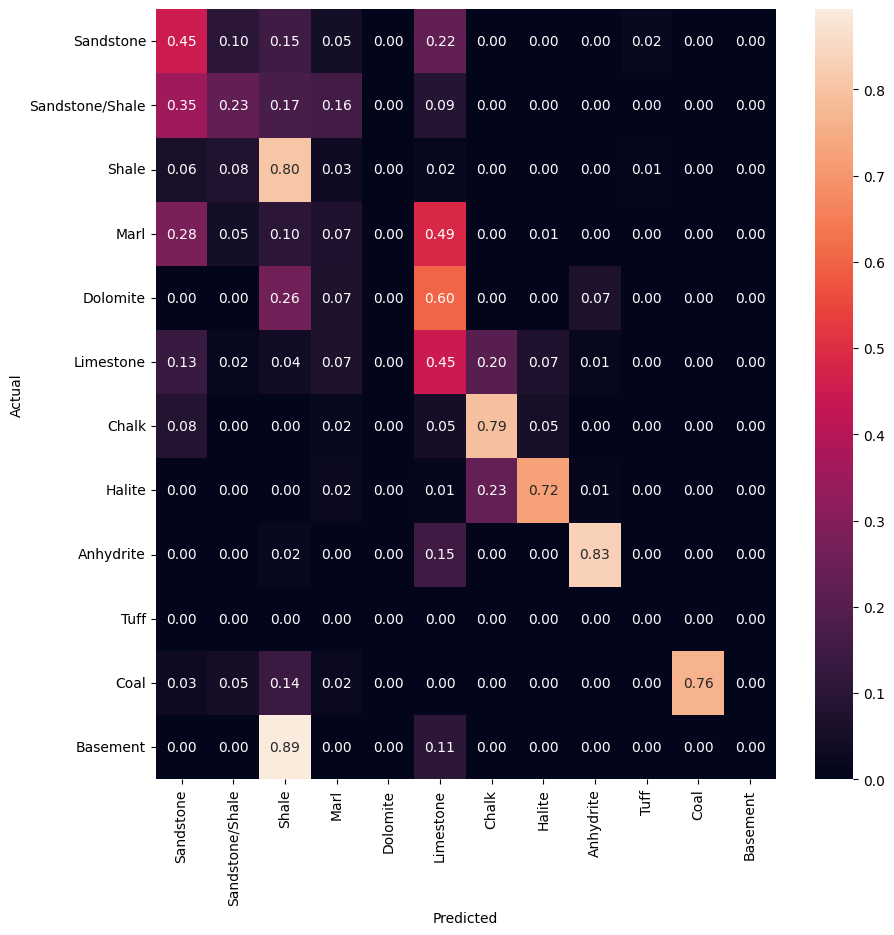

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix = ConfusionMatrix(task = 'multiclass', num_classes = 12).to(device)
cm = confusion_matrix(labels, predictions).cpu()
cm = (cm.float() / cm.sum(axis=1)[:, np.newaxis]).nan_to_num()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=lithology_keys.values(), yticklabels=lithology_keys.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)